# Three questions to answer in this analysis
1. Which genre of a movie should Microsoft create?
1. What is the size of the budget required and the expected revenue size?
1. What should be the cast of the movie to maximize gross revenue and rating?

# Which genre of a movie should Microsoft create?

As a new entrant to movie industry, the management of Microsoft is required to explain the rationale of the entry to its stakeholders. One of the most frequently used metrics is ROI. We defined ROI as Revenue / Budget, and created scatter plots for each of the 10 most popular genres.

Based on the analysis below, we propose Microsoft should consider creating horror movie for three reasons.
1. Horror genres has the highest expected ROI among the top 10 most popular genres.
1. The budget required to create horror movie is smaller than the other high ROI category. As a new entrant to this market, starting in small size is preferable.
1. The average ROI of horror movie is on the increase in the past 20 years, likely a result of increasing consumer preference to this genre.

## Calculating ROI for each of the 10 most popular genres

In [1]:
# import libraries and set style
import pandas as pd
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import itertools
from scipy import stats
sns.set(style='darkgrid')

# create connection to SQL server
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

In [2]:
# define functions for data cleaning.
def remove_dollar(value):
    return value.replace(',', '').replace('$', '') 

def million(number):
    number_int = int(number)
    return round(number_int / 1000000)

In [3]:
# loading budget table as is.
df_budget = pd.read_sql_query("""
SELECT *
FROM tn_movie_budgets
""", con)

In [4]:
# loading tn-movie table as is.
df_basics = pd.read_sql_query("""
SELECT *
FROM imdb_title_basics
""", con)

In [5]:
# remove space and change to lower-case to increase the chance of matching when merging two tables using the title of the movies.
df_budget['movie'] = df_budget['movie'].map(lambda x: x.lower()).map(lambda x: x.replace(' ', ''))
df_basics['primary_title'] = df_basics['primary_title'].map(lambda x: x.lower()).map(lambda x: x.replace(' ', ''))

In [6]:
# merge two tables on the name of titles.
df = pd.merge(df_budget, df_basics, left_on='movie', right_on='primary_title', how='inner', suffixes=('', '_r'))

In [9]:
# create original copy for later use
df_new = df.copy()

In [10]:
# removing rows with no genre information (74 rows out of total 3,930 rows)
df = df.loc[df['genres'] != '']

In [11]:
# Separating multiple genres in column ('genres')
df['genres'] = df['genres'].map(lambda x: x.split(','))

genres = []
for number in range(len(df)):
    genre = df.iloc[number, 11]
    genres.append(genre)

genres = list(itertools.chain.from_iterable(genres))
c = collections.Counter(genres)
c2 = c.most_common()[:10]

topten_genres_separated = []
for x in range(10):
    a, b = c2[x]
    topten_genres_separated.append(a)

In [12]:
# display top 10 genres
topten_genres_separated

['Drama',
 'Comedy',
 'Action',
 'Thriller',
 'Documentary',
 'Adventure',
 'Horror',
 'Crime',
 'Romance',
 'Biography']

In [13]:
# change data type to int and change unit to $MM
df_new['production_budget'] = df_new['production_budget'].map(remove_dollar).astype(int).map(lambda x: round(x / 1000000))
df_new['domestic_gross'] = df_new['domestic_gross'].map(remove_dollar).astype(int).map(lambda x: round(x / 1000000))
df_new['worldwide_gross'] = df_new['worldwide_gross'].map(remove_dollar).map(million)
df_new['total_revenue'] = df_new['domestic_gross'] + df_new['worldwide_gross']

C:\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


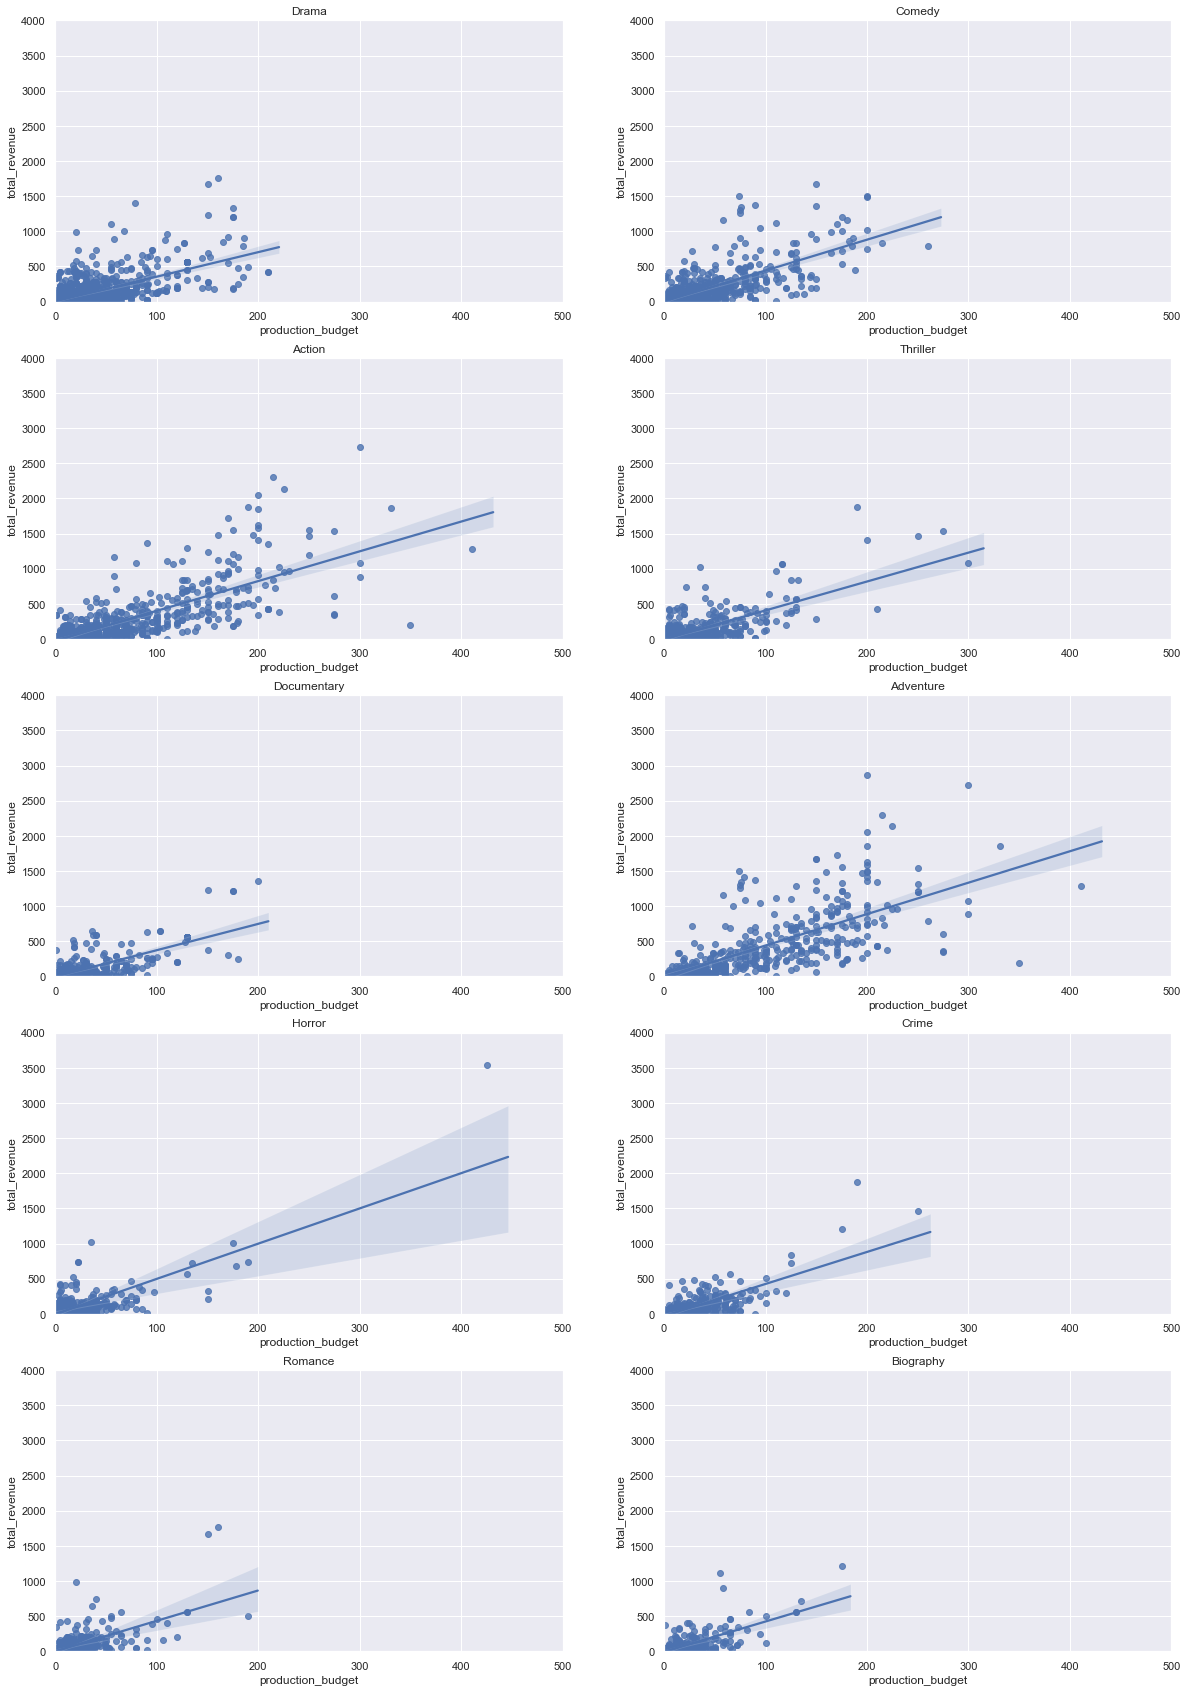

In [14]:
# Using for-loop to create regression plots and calcurate correlation coeffiient for each of the top ten genres.

coefficients = []
slopes = []
fig = plt.figure(figsize=(20,30))

for number, genre in enumerate(topten_genres_separated):
    # filter by genre
    df_bygenre = df_new[df_new['genres'].str.contains(genre)]

    # create regplot using 
    ax = fig.add_subplot(5, 2, number+1)
    plt.title(genre)
    sns.regplot(data=df_bygenre, x='production_budget', y='total_revenue')
    
    ax.set_xlim([0, 500])
    ax.set_ylim([0, 4000])
    
    coefficient = np.corrcoef(df_bygenre['production_budget'], df_bygenre['total_revenue'])
    coefficients.append(round(coefficient[0, 1], 2))
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_bygenre['production_budget'], df_bygenre['total_revenue'])
    slopes.append(round(slope, 2))


Text(0, 0.5, 'correlation coefficient of the estimate')

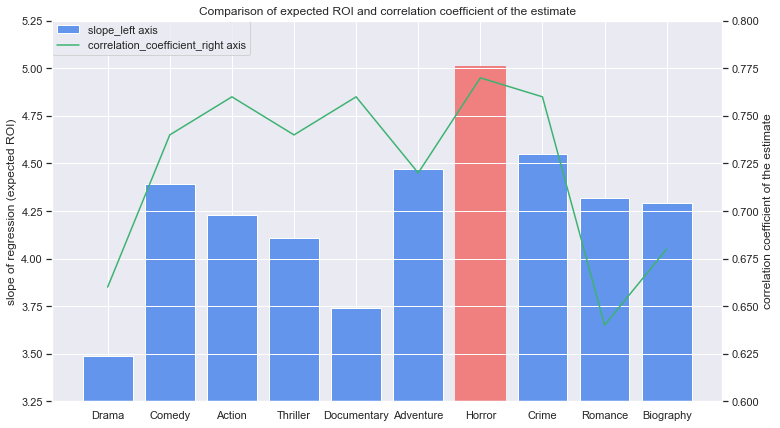

In [15]:
# visualization
plt.style.use('seaborn-pastel')

fig, ax1 = plt.subplots(figsize = (12,7))
ax2 = ax1.twinx()

bar = ax1.bar(topten_genres_separated, slopes, label='slope_left axis', color = 'cornflowerblue')
plot = ax2.plot(topten_genres_separated, coefficients, label='correlation_coefficient_right axis', color = 'mediumseagreen')
bar[6].set_color('lightcoral')

# setting legends
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

# setting limits on y-axis
ax1.set_ylim([3.25, 5.25])
ax2.set_ylim([0.6, 0.8])

# setting titles and axis labels
ax1.set_title('Comparison of expected ROI and correlation coefficient of the estimate')
ax1.set_ylabel('slope of regression (expected ROI)')
ax2.set_ylabel('correlation coefficient of the estimate')

By comparing the slope of regression lines above, "Horror" is the genre with the highest expected ROI (5.0). As a new entrant to the movie market, it is important for Microsoft to choose the most capital efficient genres initially.

*In the analysis above, we decided to divide the genres that covers multiple genres (for example, "Adventure, Animation, Comedy") into each genre ("Adventure", "Animation", "Comedy") and took such movies into consideration in each of the genres.

## Calcurating the recent trend of ROI of Horror movie

Below code is calcurating the recent trend of ROI of Horror movie. As the graph shows, the ROI of Horror movie is on the increase, potentially reflecting recent preference of consumers. 

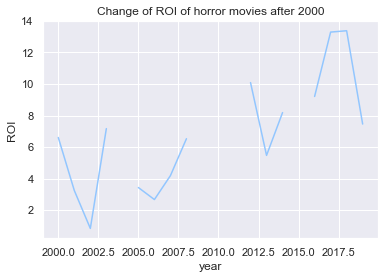

In [16]:
# Keep only the rows that includes 'Horror' in genres column
df_new_horror = df_new[df_new['genres'].str.contains('Horror')].copy()

# Creating new columns that shows release year
df_new_horror['release_date'] = pd.to_datetime(df_new_horror['release_date'])
df_new_horror['year'] = df_new_horror['release_date'].map(lambda x: x.year)

# calcurate ROI
df_new_horror['ROI'] = df_new_horror['total_revenue'] / df_new_horror['production_budget']

# group by 'year' and calcurate mean of ROI in each year
df_new_horror_ROI = pd.DataFrame(df_new_horror.groupby('year').mean()['ROI'])

# only show years after 2000
df_new_horror_ROI = df_new_horror_ROI.reset_index()
df_new_horror_ROI_after = df_new_horror_ROI[df_new_horror_ROI['year']>= 2000]

# create lineplot
plt.title('Change of ROI of horror movies after 2000')
sns.lineplot(data=df_new_horror_ROI_after, x='year', y='ROI')


# What is the size of required budget and expected revenue?

As Microsoft considers entry of Horror movie market, one of the most important questions that the management of Microsoft should answer is the required budget size and expected (or target) revenue. Using the data we used to answer the previous question, we created whisker plot to visualize the estimate.

Based on the whisker plots below, 75% of horror movie had budget less than 25MM and only achieved 100MM for the revenue. However, Microsoft has much resources compared with existing players in the market, therefore, Microsoft should aim higher than 75 percentile figure. Speficically, they should spend 25MM-50MM and aim to achieve 300MM+ in revenue.

*whisker plots below is only showing values close to center for readability, but all analysis includes outliers that had huge budget and and revenue. This is because Microsoft is a company with a lot of resouces and may spend large budget to aim huge revenue, therefore, those that had significant size of budget are not considered as "outliers" for Microsoft. 

C:\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 600)

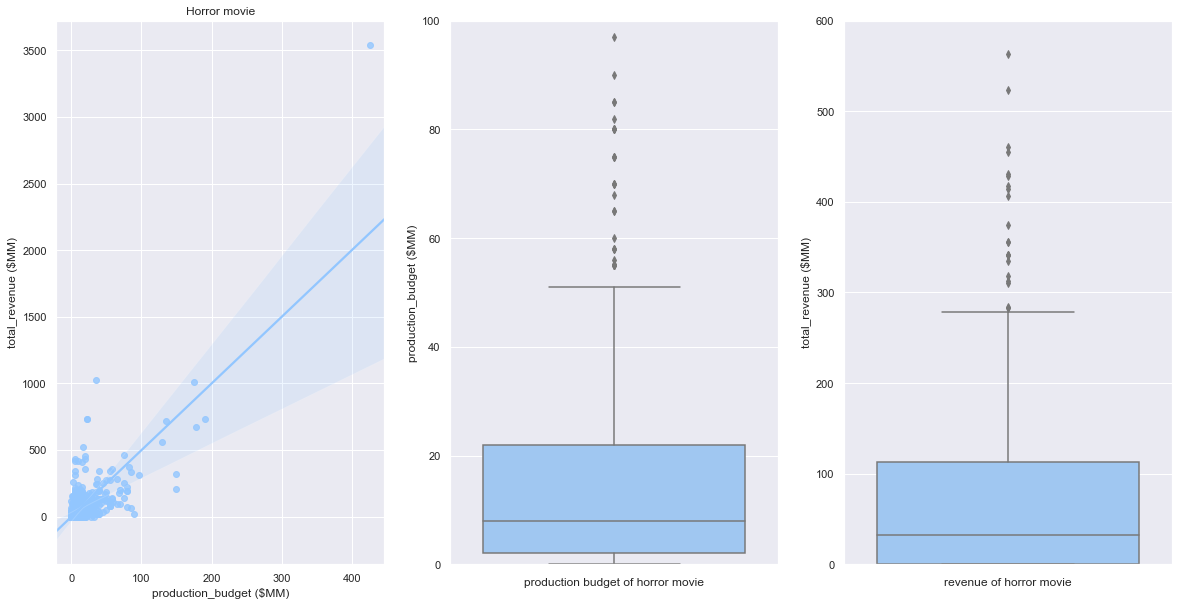

In [17]:
# filter by genre
df_bygenre_horror = df_new[df_new['genres'].str.contains('Horror')]

# create visualization
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 3, 1)

# create regplot
plt.title('Horror movie')
sns.regplot(data=df_bygenre_horror, x='production_budget', y='total_revenue')
plt.xlabel('production_budget ($MM)')
plt.ylabel('total_revenue ($MM)')

# create box plot
ax2 = fig.add_subplot(1, 3, 2)
sns.boxplot(data=df_bygenre_horror, y='production_budget')
plt.xlabel('production budget of horror movie')
plt.ylabel('production_budget ($MM)')

ax3 = fig.add_subplot(1, 3, 3)
sns.boxplot(data=df_bygenre_horror, y='total_revenue')
plt.xlabel('revenue of horror movie')
plt.ylabel('total_revenue ($MM)')

# setting limit on y-axis
ax2.set_ylim([0, 100])
ax3.set_ylim([0, 600])


# What should be the cast of the movie to maximize gross revenue and rating?